<a href="https://colab.research.google.com/github/howardx/agentic/blob/main/demo_call.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install --quiet -U langgraph langchain_openai langchain_core serpapi google-search-results

In [6]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("SERP_API_KEY")

OPENAI_API_KEY: ··········
SERP_API_KEY: ··········


In [7]:
import os
from serpapi.google_search import GoogleSearch
from typing import List, Dict

def get_airfare_details(
    departure_airport: str,
    destination_airport: str,
    departure_date: str,
    return_date: str
) -> List[Dict]:
    """
    Fetch round-trip airfare details between two airports using SerpAPI's Google Flights engine.

    Args:
        departure_airport (str): IATA airport code of the departure location (e.g., "CDG").
        destination_airport (str): IATA airport code of the destination (e.g., "SFO").
        departure_date (str): Outbound flight date in format YYYY-MM-DD.
        return_date (str): Return flight date in format YYYY-MM-DD.

    Returns:
        List[Dict]: A list of flights (both outbound and return), where each flight dict includes:
            - flight_number (str)
            - airline (str)
            - departure_time (str)
            - arrival_time (str)
            - departure_airport (str)
            - arrival_airport (str)
            - price (float)
            - departure_token (str)
    """
    def extract_flight_segments(flight_data: Dict, price: float, token: str) -> List[Dict]:
        return [
            {
                "flight_number": seg.get("flight_number"),
                "airline": seg.get("airline"),
                "departure_time": seg["departure_airport"].get("time"),
                "arrival_time": seg["arrival_airport"].get("time"),
                "departure_airport": seg["departure_airport"].get("id"),
                "arrival_airport": seg["arrival_airport"].get("id"),
                "price": price,
                "departure_token": token
            }
            for seg in flight_data.get("flights", [])
        ]

    # First search: outbound
    params = {
        "engine": "google_flights",
        "hl": "en",
        "gl": "us",
        "departure_id": departure_airport,
        "arrival_id": destination_airport,
        "outbound_date": departure_date,
        "return_date": return_date,
        "currency": "USD",
        "api_key": os.environ.get("SERP_API_KEY")
    }

    search = GoogleSearch(params)
    results = search.get_dict()

    best_flight = results.get("best_flights", [])[0] if results.get("best_flights") else None
    if not best_flight:
        return []

    outbound_segments = extract_flight_segments(
        best_flight,
        best_flight.get("price"),
        best_flight.get("departure_token")
    )

    # Second search: return
    params["departure_token"] = best_flight.get("departure_token")
    return_search = GoogleSearch(params)
    return_results = return_search.get_dict()

    return_flight = return_results.get("other_flights", [])[0] if return_results.get("other_flights") else None
    if not return_flight:
        print(return_results)
        return outbound_segments

    return_segments = extract_flight_segments(
        return_flight,
        best_flight.get("price"),
        best_flight.get("departure_token")
    )

    return outbound_segments + return_segments

In [8]:
get_airfare_details("DFW", "SFO", "2025-07-01", "2025-07-07")

[{'flight_number': 'UA 790',
  'airline': 'United',
  'departure_time': '2025-07-01 06:00',
  'arrival_time': '2025-07-01 07:46',
  'departure_airport': 'DFW',
  'arrival_airport': 'SFO',
  'price': 262,
  'departure_token': 'WyJDalJJVUZnek9YRm5RVFJuU2tWQlNXVk5kWGRDUnkwdExTMHRMUzB0TFhaM1ltZHpORUZCUVVGQlIyaE9abVl3VGs1MFNEQkJFZ1ZWUVRjNU1Cb0xDTlRNQVJBQ0dnTlZVMFE0SEhEVXpBRT0iLFtbIkRGVyIsIjIwMjUtMDctMDEiLCJTRk8iLG51bGwsIlVBIiwiNzkwIl1dXQ=='},
 {'flight_number': 'UA 1944',
  'airline': 'United',
  'departure_time': '2025-07-07 23:05',
  'arrival_time': '2025-07-08 04:49',
  'departure_airport': 'SFO',
  'arrival_airport': 'DFW',
  'price': 262,
  'departure_token': 'WyJDalJJVUZnek9YRm5RVFJuU2tWQlNXVk5kWGRDUnkwdExTMHRMUzB0TFhaM1ltZHpORUZCUVVGQlIyaE9abVl3VGs1MFNEQkJFZ1ZWUVRjNU1Cb0xDTlRNQVJBQ0dnTlZVMFE0SEhEVXpBRT0iLFtbIkRGVyIsIjIwMjUtMDctMDEiLCJTRk8iLG51bGwsIlVBIiwiNzkwIl1dXQ=='}]

In [9]:
def city_to_iata(city_name: str) -> str:
    """
    Converts a popular city name to its nearest major airport's IATA (International Air Transport Association) code.

    Args:
        city_name (str): Common name of a city (e.g., "New York", "Paris").

    Returns:
        str: The IATA airport code (e.g., "JFK", "CDG") or "Unknown" if not found.
    """
    city_iata_map = {
        "new york": "JFK",
        "los angeles": "LAX",
        "san francisco": "SFO",
        "chicago": "ORD",
        "miami": "MIA",
    }

    return city_iata_map.get(city_name.strip().lower(), "Unknown")

In [10]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo")
plain_llm = ChatOpenAI(model="gpt-3.5-turbo")

In [12]:
tools = [get_airfare_details, city_to_iata]
llm_with_tools = llm.bind_tools(tools)  # source code: puts tools into a dictionary of the LLM client

In [13]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage

# System message
sys_msg = SystemMessage(content="""
You are a knowledgeable and helpful travel planning assistant.
Your task is to create a detailed travel itinerary based on the user's chosen destination. You should:

Search for and summarize flight options, including airline, departure/arrival time, flight number, layovers, and price.
Use tools when appropriate to fetch live airfare information.
The tool get_airfare_details is able to give you round trip airfare information with one call.

Organize the itinerary clearly, separating outbound and return details.
""")

# Node
def assistant(state: MessagesState): # source code: state, keeps track of the conversation between human, LLM and tools
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

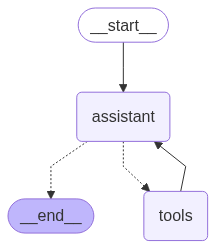

In [14]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,  # source code, routes the workflow based on LLM's reason
)
builder.add_edge("tools", "assistant")
graph = builder.compile()
graph

In [15]:
user_prompt = """help me to find the best airfare from San Francisco to new york during the July forth holiday,
I will be departing around July 1 2025 visiting for five days"""

print(plain_llm.invoke(user_prompt).content)

To find the best airfare for your trip from San Francisco to New York during the July 4th holiday, you can follow these steps:

1. Use a flight comparison website or app such as Google Flights, Skyscanner, or Kayak to search for flights from San Francisco to New York around July 1, 2025.

2. Enter your travel dates (July 1, 2025) and select the option for a round trip if you will be returning after five days.

3. Compare the prices and options from different airlines and try to be flexible with your travel dates and times to potentially find a cheaper fare.

4. Consider booking your flight in advance as prices tend to increase closer to the travel date, especially during busy holiday periods like July 4th.

5. Keep an eye out for any discounts, promotions, or special deals that airlines may be offering for the holiday period.

6. Once you have found a flight that fits your budget and schedule, book it as soon as possible to secure the best price.

By following these tips and using flig

In [16]:
messages = [HumanMessage(content=user_prompt)]
messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

help me to find the best airfare from San Francisco to new york during the July forth holiday,
I will be departing around July 1 2025 visiting for five days
================================== Ai Message ==================================
Tool Calls:
  city_to_iata (call_RSSS4deLxNbzkkspK1pmOLbx)
 Call ID: call_RSSS4deLxNbzkkspK1pmOLbx
  Args:
    city_name: San Francisco
================================= Tool Message =================================
Name: city_to_iata

SFO
================================== Ai Message ==================================
Tool Calls:
  city_to_iata (call_Zbfwwo9H6zYs9QEjrzkWcJ2h)
 Call ID: call_Zbfwwo9H6zYs9QEjrzkWcJ2h
  Args:
    city_name: New York
================================= Tool Message =================================
Name: city_to_iata

JFK
================================== Ai Message ==================================
Tool Calls:
  get_airfare_details (call_Y